In [1]:
# single-graph node, no meta setting

import os
os.chdir('../graphwave/')

%matplotlib inline
import networkx as nx 
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torch
import pickle
import dgl
from tqdm import tqdm

import matplotlib.pyplot as plt
import graphwave
from graphwave.shapes import build_graph

def generate_single_cycle_basis_network(width_basis, n_shapes, add_random_edges_num, data_folder):

    width_basis = width_basis

    ### 1. Choose the basis (cycle, torus or chain)
    basis_type = "cycle" 

    ### 2. Add the shapes 
    n_shapes = n_shapes  
    list_shapes = [["house"]] * n_shapes + [["diamond"]] * n_shapes + [["star", 6]] * n_shapes + [["fan", 6]] * n_shapes

    ### 3. Pass all these parameters to the Graph Structure
    add_edges = add_random_edges_num # random edges to add
    G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                           add_random_edges=add_edges, plot=False,
                                           savefig=False)
    d = dict(zip(np.unique(role_id), range(len(np.unique(role_id)))))
    labels = np.array([d[i] for i in role_id])
    print(len(np.unique(role_id)))
    
    info = {}
    total_subgraph = {}
    center_nodes = {}

    idx = 0
    h = 2

    features = torch.eye(G.number_of_nodes())

    for i in list(G.nodes):
        h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
        features_temp = features[h_hops_neighbor]
        features_temp = features_temp[np.argsort(h_hops_neighbor)]
        S = dgl.DGLGraph()
        S.from_networkx(G.subgraph(h_hops_neighbor))
        S.ndata['h'] = features_temp
        info[str(idx) + '_' + str(i)] = labels[i]
        total_subgraph[str(idx) + '_' + str(i)] = S
        center_nodes[str(idx) + '_' + str(i)] = np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]
    
    np.save(data_folder + 'graph_adj.npy', nx.adjacency_matrix(G).todense())

    path = data_folder
    
    with open(path + '/list_subgraph.pkl', 'wb') as f:
        pickle.dump(total_subgraph, f)

    with open(path + '/label.pkl', 'wb') as f:
        pickle.dump(info, f)

    with open(path + '/center.pkl', 'wb') as f:
        pickle.dump(center_nodes, f)

    df = pd.DataFrame.from_dict(info, orient='index').reset_index().rename(columns={"index": "name", 0: "label"})
    df.to_csv(path + '/data.csv')
    
    path = data_folder + '/fold'
    
    for idx in range(1,6):  
        path = data_folder + '/fold' + str(idx)
        np.random.seed(idx)
        labeled_nodes = np.random.choice(list(range(G.number_of_nodes())), int(G.number_of_nodes() * 0.15), replace = False)
        unlabelled_nodes = [i for i in list(range(G.number_of_nodes())) if i not in labeled_nodes]
        val_nodes = np.random.choice(unlabelled_nodes, int(len(unlabelled_nodes)*0.2), replace = False)
        test_nodes = [i for i in unlabelled_nodes if i not in val_nodes]
        df[df.index.isin(labeled_nodes)].reset_index(drop = True).to_csv(path + '/train.csv')
        df[df.label.index.isin(val_nodes)].reset_index(drop = True).to_csv(path + '/val.csv')    
        df[df.label.index.isin(test_nodes)].reset_index(drop = True).to_csv(path + '/test.csv')

    return df, G, info, total_subgraph

In [24]:
width_basis = 50
n_shapes = 10
add_random_edges_num = 100
data_folder = '../data/single_graph/cycle/'
df, G, info, total_subgraph = generate_single_cycle_basis_network(width_basis, n_shapes, add_random_edges_num, data_folder)

17


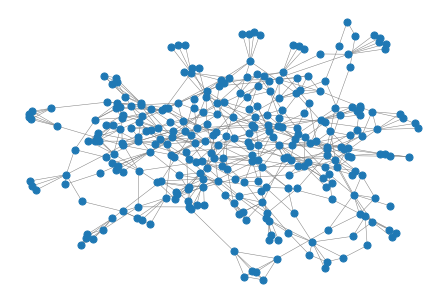

In [25]:
nx.draw(G, node_size=50, edge_color="gray", width=0.5)

In [26]:
df.label.value_counts()

11    60
9     50
15    30
14    20
6     20
16    10
5     10
1     10
2     10
3     10
4     10
8     10
7     10
10    10
12    10
13    10
0     10
Name: label, dtype: int64

In [136]:
len(G)

270

In [137]:
len(G.edges)

518

In [28]:
def generate_single_caveman_basis_network(l, k, p, split, data_folder):
    G = nx.relaxed_caveman_graph(l, k, p, seed=42)

    labels = list(range(l))
    labels = [[i] * k for i in labels]
    labels = np.array(labels).flatten()

    # inject features as labels
    features = np.zeros((labels.shape[0], l))
    for i in range(l):
        features[i*k : i*k+k, i] = 1

    h = 2
    idx = 0
    info = {}
    total_subgraph = {} 
    center_node = {}

    for i in tqdm(list(G.nodes)):
        h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
        features_temp = features[h_hops_neighbor]
        features_temp = features_temp[np.argsort(h_hops_neighbor)]
        labels_temp = labels[h_hops_neighbor]
        labels_temp = labels_temp[np.argsort(h_hops_neighbor)]

        S = dgl.DGLGraph()
        S.from_networkx(G.subgraph(h_hops_neighbor))
        S.ndata['h'] = features_temp
        S.ndata['y'] = labels_temp

        info[str(idx) + '_' + str(i)] = labels[i]
        total_subgraph[str(idx) + '_' + str(i)] = S
        center_node[str(idx) + '_' + str(i)] = np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]            

        
    path = data_folder
    
    with open(path + '/list_subgraph.pkl', 'wb') as f:
        pickle.dump(total_subgraph, f)

    with open(path + '/label.pkl', 'wb') as f:
        pickle.dump(info, f)

    with open(path + '/center.pkl', 'wb') as f:
        pickle.dump(center_node, f)

    df = pd.DataFrame.from_dict(info, orient='index').reset_index().rename(columns={"index": "name", 0: "label"})
    df.to_csv(path + '/data.csv')
    
    np.save(data_folder + 'graph_adj.npy', nx.adjacency_matrix(G).todense())

    path = data_folder + '/fold'
    
    for idx in range(1,6):  
        path = data_folder + '/fold' + str(idx)
        np.random.seed(idx)
        labeled_nodes = np.random.choice(list(range(G.number_of_nodes())), int(G.number_of_nodes() * split[0]), replace = False)
        unlabelled_nodes = [i for i in list(range(G.number_of_nodes())) if i not in labeled_nodes]
        val_nodes = np.random.choice(unlabelled_nodes, int(len(unlabelled_nodes)*split[1]), replace = False)
        test_nodes = [i for i in unlabelled_nodes if i not in val_nodes]
        df[df.index.isin(labeled_nodes)].reset_index(drop = True).to_csv(path + '/train.csv')
        df[df.label.index.isin(val_nodes)].reset_index(drop = True).to_csv(path + '/val.csv')    
        df[df.label.index.isin(test_nodes)].reset_index(drop = True).to_csv(path + '/test.csv')
    
    return df, G

In [29]:
l = 10
k = 30
p = 0.3
split = [0.5, 0.2]
data_folder = '../data/single_graph/caveman/'
df, G = generate_single_caveman_basis_network(l, k, p, split, data_folder)

100%|██████████| 300/300 [00:12<00:00, 24.96it/s]


In [30]:
len(G.edges)

4350

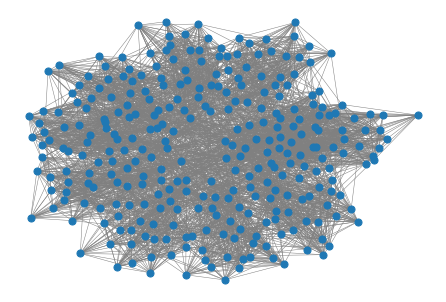

In [31]:
nx.draw(G, node_size=50, edge_color="gray", width=0.5)

In [2]:
# borrow from OrbitalFeatures github
import pandas as pd
from tqdm import tqdm
import networkx as nx
from networkx.generators.atlas import *
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

class MotifCounterMachine(object):
    """
    Connected motif orbital role counter.
    """
    def __init__(self, graph, graphlet_size):
        """
        Creating an orbital role counter machine.
        :param graph: NetworkX graph.
        :param args: Arguments object.
        """
        self.graph = graph
        self.graphlet_size = graphlet_size

    def create_edge_subsets(self):
        """
        Enumerating connected subgraphs with size 2 up to the graphlet size.
        """
        print("\nEnumerating subgraphs.\n")
        self.edge_subsets = dict()
        subsets = [[edge[0], edge[1]] for edge in self.graph.edges()]
        self.edge_subsets[2] = subsets
        unique_subsets = dict()
        for i in range(3, self.graphlet_size+1):
            print("Enumerating graphlets with size: " +str(i) + ".")
            for subset in tqdm(subsets):
                for node in subset:
                    for neb in self.graph.neighbors(node):
                        new_subset = subset+[neb]
                        if len(set(new_subset)) == i:
                            new_subset.sort()
                            unique_subsets[tuple(new_subset)] = 1
            subsets = [list(k) for k, v in unique_subsets.items()]
            self.edge_subsets[i] = subsets
            unique_subsets = dict()

    def enumerate_graphs(self):
        """
        Creating a hash table of the benchmark motifs.
        """
        graphs = graph_atlas_g()
        self.interesting_graphs = {i: [] for i in range(2, self.graphlet_size+1)}
        for graph in graphs:
            if graph.number_of_nodes() > 1 and graph.number_of_nodes() < self.graphlet_size+1:
                if nx.is_connected(graph):
                    self.interesting_graphs[graph.number_of_nodes()].append(graph)

    def enumerate_categories(self):
        """
        Creating a hash table of benchmark orbital roles.
        """
        main_index = 0
        self.categories = dict()
        for size, graphs in self.interesting_graphs.items():
            self.categories[size] = dict()
            for index, graph in enumerate(graphs):
                self.categories[size][index] = dict()
                degrees = list(set([graph.degree(node) for node in graph.nodes()]))
                for degree in degrees:
                    self.categories[size][index][degree] = main_index
                    main_index = main_index + 1
        self.unique_motif_count = main_index + 1

    def setup_features(self):
        """
        Counting all the orbital roles.
        """
        print("\nCounting orbital roles.\n")
        self.features = {node: {i:0 for i in range(self.unique_motif_count)}for node in self.graph.nodes()}
        for size, node_lists in self.edge_subsets.items():
            graphs = self.interesting_graphs[size]
            for nodes in tqdm(node_lists):
                sub_gr = self.graph.subgraph(nodes)
                for index, graph in enumerate(graphs):
                    if nx.is_isomorphic(sub_gr, graph):
                        for node in sub_gr.nodes():
                            self.features[node][self.categories[size][index][sub_gr.degree(node)]] += 1
                        break

    def create_tabular_motifs(self):
        """
        Creating a table with the orbital role features.
        """
        print("Saving the dataset.")
        self.binned_features = {node: [] for node in self.graph.nodes()}
        self.motifs = [[n]+[self.features[n][i] for i in  range(self.unique_motif_count)] for n in self.graph.nodes()]
        self.motifs = pd.DataFrame(self.motifs)
        self.motifs.columns = ["id"] + ["role_"+str(index) for index in range(self.unique_motif_count)]
        #self.motifs.to_csv(self.args.output, index=None)

    def extract_features(self):
        """
        Executing steps for feature extraction.
        """
        self.create_edge_subsets()
        self.enumerate_graphs()
        self.enumerate_categories()
        self.setup_features()
        self.create_tabular_motifs()
        print('motif extracted')

In [3]:
from graphwave.shapes.shapes import *

def generate_BA_single(n, s, n_shapes, data_folder, split):

    basis = nx.barabasi_albert_graph(n, s)
    n_shapes = n_shapes  
    list_shapes = [["house"]] * n_shapes + [["diamond"]] * n_shapes + [["star", 5]] * n_shapes + [["fan", 5]] * n_shapes

    n_basis, n_shapes = nx.number_of_nodes(basis), len(list_shapes)

    plugins = np.random.choice(n_basis, n_shapes, replace=False)

    communities = [0] * n_basis
    seen_shapes = {'basis': [0, n_basis]}
    
    #start = n
    
    for shape_id, shape in enumerate(list_shapes):
        shape_type = shape[0]
        start = np.random.choice(n-10)
        args = [start]
        if len(shape)>1:
            args += shape[1:]
        args += [0]
        graph_s, roles_graph_s = eval(shape_type)(*args)
        #n_s = nx.number_of_nodes(graph_s)
        #basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        #basis.add_edges_from([(start, plugins[shape_id])])
        #print(len(basis))
        #start += n_s
        
    G = basis
    m = MotifCounterMachine(G, 5)
    m.extract_features()
    X = m.motifs.values
    clustering = SpectralClustering(n_clusters=15,
             assign_labels="discretize",
            random_state=0).fit(X)
    dict_label = pd.Series(clustering.labels_).value_counts().to_dict()

    merge_labels = np.array(list(dict_label.keys()))[np.array(list(dict_label.values()))<5]
    new_labels = [-1 if i in merge_labels else i for i in clustering.labels_]
    d = dict(zip(np.unique(new_labels), range(len(np.unique(new_labels)))))
    labels = np.array([d[i] for i in new_labels])

    # inject features as labels
    features = torch.eye(G.number_of_nodes())

    h = 2
    idx = 0
    info = {}
    total_subgraph = {} 
    center_node = {}

    for i in tqdm(list(G.nodes)):
        h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
        features_temp = features[h_hops_neighbor]
        features_temp = features_temp[np.argsort(h_hops_neighbor)]
        labels_temp = labels[h_hops_neighbor]
        labels_temp = labels_temp[np.argsort(h_hops_neighbor)]

        S = dgl.DGLGraph()
        S.from_networkx(G.subgraph(h_hops_neighbor))
        S.ndata['h'] = features_temp
        S.ndata['y'] = labels_temp

        info[str(idx) + '_' + str(i)] = labels[i]
        total_subgraph[str(idx) + '_' + str(i)] = S
        center_node[str(idx) + '_' + str(i)] = np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]            

    path = data_folder
    
    with open(path + '/list_subgraph.pkl', 'wb') as f:
        pickle.dump(total_subgraph, f)

    with open(path + '/label.pkl', 'wb') as f:
        pickle.dump(info, f)

    with open(path + '/center.pkl', 'wb') as f:
        pickle.dump(center_node, f)

    df = pd.DataFrame.from_dict(info, orient='index').reset_index().rename(columns={"index": "name", 0: "label"})
    df.to_csv(path + '/data.csv')
    
    np.save(data_folder + 'graph_adj.npy', nx.adjacency_matrix(G).todense())
    
    path = data_folder + '/fold'
    
    for idx in range(1,6):  
        path = data_folder + '/fold' + str(idx)
        np.random.seed(idx)
        labeled_nodes = np.random.choice(list(range(G.number_of_nodes())), int(G.number_of_nodes() * split[0]), replace = False)
        unlabelled_nodes = [i for i in list(range(G.number_of_nodes())) if i not in labeled_nodes]
        val_nodes = np.random.choice(unlabelled_nodes, int(len(unlabelled_nodes)*split[1]), replace = False)
        test_nodes = [i for i in unlabelled_nodes if i not in val_nodes]
        df[df.index.isin(labeled_nodes)].reset_index(drop = True).to_csv(path + '/train.csv')
        df[df.label.index.isin(val_nodes)].reset_index(drop = True).to_csv(path + '/val.csv')    
        df[df.label.index.isin(test_nodes)].reset_index(drop = True).to_csv(path + '/test.csv')
    
    return df, G, m

In [4]:
n = 200
s = 3
n_shapes = 5
split = [0.5, 0.2]
data_folder = '../data/single_graph/BA/'
df, G, m = generate_BA_single(n, s, n_shapes, data_folder, split)

 26%|██▌       | 2031/7821 [00:00<00:00, 20295.41it/s]


Enumerating subgraphs.

Enumerating graphlets with size: 3.
Enumerating graphlets with size: 4.


  2%|▏         | 2864/119445 [00:00<00:08, 13726.43it/s]

Enumerating graphlets with size: 5.


  0%|          | 0/7821 [00:00<?, ?it/s]


Counting orbital roles.



100%|██████████| 2019523/2019523 [34:09<00:00, 985.57it/s] 
/Users/kexinhuang/torch-env/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
  6%|▌         | 12/200 [00:00<00:01, 118.03it/s]

Saving the dataset.
motif extracted


100%|██████████| 200/200 [00:00<00:00, 270.60it/s]


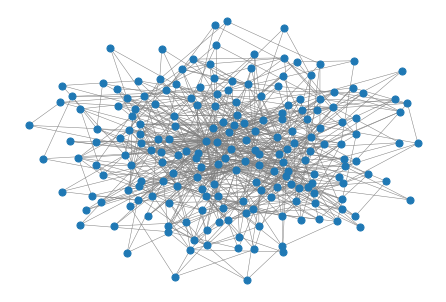

In [5]:
nx.draw(G, node_size=50, edge_color="gray", width=0.5)

In [6]:
len(G.edges)

742

In [196]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.87648256 0.09776763 0.01561036]


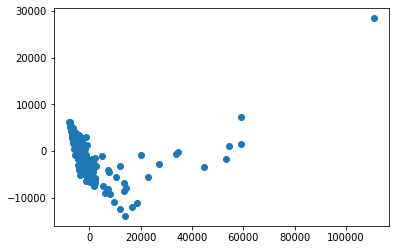

In [197]:
plt.scatter(pca_result[:,0], pca_result[:,1])

In [198]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 334.903554
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.987682
[t-SNE] KL divergence after 300 iterations: 0.184518


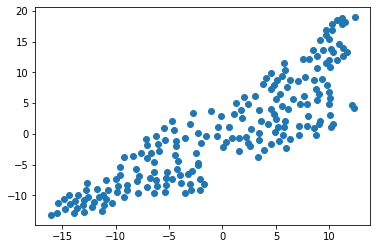

In [199]:
plt.scatter(tsne_results[:,0], tsne_results[:,1])

In [ ]:
# generate multiple cycle graphs

In [34]:
n_shapes_list = [[15,1,1,1], [1,15,1,1], [1,1,15,1], [1,1,1,15]] + [list(np.random.choice(np.array(range(1,15)), 4)) for i in range(6)]
width_basis = 50

In [159]:
n_shapes_list

[[15, 1, 1, 1],
 [1, 15, 1, 1],
 [1, 15, 1, 1],
 [1, 1, 1, 15],
 [8, 2, 2, 2],
 [9, 6, 3, 7],
 [6, 13, 12, 2],
 [11, 12, 3, 14],
 [8, 13, 13, 9],
 [14, 13, 7, 11]]

In [64]:
path = '../data/multiple_graph/cycle/'

width_basis = 50
basis_type = "cycle" 
    
info = {}
total_subgraph = {}
center_nodes = {}

adjs = []
labels_set = []
h = 2

for idx, k in enumerate(range(len(n_shapes_list))):
    n_shapes = n_shapes_list[k]  
    list_shapes = [["house"]] * n_shapes[0] + [["diamond"]] * n_shapes[1] + [["star", 6]] * n_shapes[2] + [["fan", 6]] * n_shapes[3]
    add_edges = add_random_edges_num 
    G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                           add_random_edges=add_edges, plot=False,
                                           savefig=False)
    adjs.append(nx.adjacency_matrix(G).todense())
    d = dict(zip(np.unique(role_id), range(len(np.unique(role_id)))))
    labels = np.array([d[i] for i in role_id])
    
    labels_set.append(labels)

    features = torch.eye(G.number_of_nodes())
    
    for i in list(G.nodes):
        h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
        features_temp = features[h_hops_neighbor]
        features_temp = features_temp[np.argsort(h_hops_neighbor)]
        S = dgl.DGLGraph()
        S.from_networkx(G.subgraph(h_hops_neighbor))
        S.ndata['h'] = features_temp
        info[str(idx) + '_' + str(i)] = labels[i]
        total_subgraph[str(idx) + '_' + str(i)] = S
        center_nodes[str(idx) + '_' + str(i)] = np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]

np.save(path + 'graphs_adj.npy', np.array(adjs))
np.save(path + 'labels_graphs.npy', np.array(labels_set))

df = pd.DataFrame.from_dict(info, orient='index').reset_index().rename(columns={"index": "name", 0: "label"})

# folds: [fold1_test_graph_index, fold1_val_graph_index], ...
folds = [[0, 4], [1, 5], [2, 6], [3, 7], [4, 8], [5, 9]]

for fold_n, i in enumerate(folds):
    temp_path = path + 'fold' + str(fold_n+1)
    train_graphs = list(range(10))
    train_graphs.remove(i[0])
    train_graphs.remove(i[1])
    val_graph = i[1]
    test_graph = i[0]
    
    val_df = df[df.name.str.contains(str(val_graph)+'_')]
    test_df = df[df.name.str.contains(str(test_graph)+'_')]
    
    train_df = df[~df.index.isin(val_df.index)]
    train_df = train_df[~train_df.index.isin(test_df.index)]
    train_df.reset_index(drop = True).to_csv(temp_path + '/train.csv')
    val_df.reset_index(drop = True).to_csv(temp_path + '/val.csv')
    test_df.reset_index(drop = True).to_csv(temp_path + '/test.csv')

In [66]:
adjs[0]

matrix([[0, 1, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)